In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
from nltk.corpus import stopwords
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 

In [28]:
purchases_df = pd.read_csv("../data/processed/enriched.csv")

### Supervised model

This following iteration is made to carry a ordinal encoding.

In [ ]:
data = purchases_df.copy()
for i, column in enumerate(list([str(d) for d in data.dtypes])):
    if column == "object":
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode())
        data[data.columns[i]] = data[data.columns[i]].astype("category").cat.codes # Assigns a similar ordinal encoding.
    else:
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mean())

In [31]:
X = data.drop(["IMPORTE"], axis=1)
y = data[["IMPORTE"]].values.ravel()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [33]:
clf = RandomForestRegressor(n_estimators=1000, max_depth = 4)
clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=1000)

In [34]:
r2_score(y_test, clf.predict(X_test))

0.18907274738790947

A very bad model, accuracy is pretty bad, but this is mainly due to a high level of dimensionality in our dataset. In this way, it was expectable.

### Testing a non-supervised model or clustering for text.

In [61]:
np.random.seed(42)

In [62]:
def preprocess(text):
    result = []
    for token in text.split():
        if token not in stopwords.words('spanish') and len(token)>4:
            result.append(token)
    return result

In [37]:
process_business = [preprocess(x) for x in purchases_df["BENEFICIARIO"].unique()]

In [ ]:
dictionary = gensim.corpora.Dictionary(process_business) # A technique to avoid rare words in the NLP model
dictionary.filter_extremes(no_below=1, no_above=0.5)

In [39]:
bow_corpus = [dictionary.doc2bow(doc) for doc in process_business]

In [40]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=dictionary, passes=10, workers=2)

In [41]:
for idx, type_business in lda_model.print_topics(-1):
    print("Topic: {} Words: {}".format(idx, type_business))

Topic: 0 Words: 0.032*"CONSTRUCTORA" + 0.023*"GARCIA" + 0.019*"GONZALEZ" + 0.014*"RAMIREZ" + 0.014*"SERVICIOS" + 0.014*"ARTURO" + 0.014*"ANDRES" + 0.010*"ORTIZ" + 0.010*"CANTU" + 0.010*"ALEJANDRO"
Topic: 1 Words: 0.016*"DESARROLLOS" + 0.016*"GARZA" + 0.016*"SANCHEZ" + 0.016*"SEGUROS" + 0.016*"GRUPO" + 0.012*"MARIA" + 0.012*"MARCELO" + 0.012*"FINANCIERO" + 0.012*"GONZALEZ" + 0.008*"INFRAESTRUCTURA"
Topic: 2 Words: 0.016*"MONTERREY," + 0.014*"MARIA" + 0.012*"CONSTRUCCIONES" + 0.012*"INSTITUTO" + 0.012*"GARCIA" + 0.012*"HERNANDEZ" + 0.012*"EDGAR" + 0.012*"URBANIZACIONES" + 0.008*"VILLARREAL" + 0.008*"ALBERTO"
Topic: 3 Words: 0.018*"MEXICO," + 0.009*"GONZALEZ" + 0.009*"PEREZ" + 0.009*"NUEVO" + 0.009*"DESARROLLO" + 0.009*"SALAZAR" + 0.009*"MARIA" + 0.009*"LEON," + 0.009*"VALUE" + 0.009*"MERCANTIL"
Topic: 4 Words: 0.024*"RODRIGUEZ" + 0.015*"SERVICIOS" + 0.012*"MARIA" + 0.010*"GOMEZ" + 0.010*"BANCO" + 0.010*"COMERCIALIZADORA" + 0.010*"TREVIÑO" + 0.010*"INMOBILIARIA" + 0.010*"GARCIA" + 0.010*"

In [42]:
def get_max_topic(index):
    results = lda_model[bow_corpus[index]]
    return max(lda_model[results], key=lambda x:x[1])[0]

In [43]:
business_cluster = {x: get_max_topic(i) for i, x in enumerate(list(purchases_df["BENEFICIARIO"].unique()))}

In [44]:
business_cluster

{'DISTRIBUIDORA DE FRUTAS Y LEGUMBRES LA HORTALIZA,S.A.DE C.V.': 3,
 'EMPACADORA Y DISTR.DE CARNES FINAS SAN JUAN,S.A.DE C.V.': 3,
 'CAR ONE AMERICANA,S.A.DE C.V.': 1,
 'GONZALEZ GARZA ROSA LILA': 3,
 'AUTOKAM REGIOMONTANA,S.A.DE C.V.': 3,
 'BUFETE URBANISTICO, S.A. DE C.V.': 1,
 'TOOLS & SERVICES DE MEXICO, S.A. DE C.V.': 1,
 'SOLUCIONES Y OPCIONES DE SEGURIDAD PRIVADA,S.A.DE C.V.': 3,
 'CAR ONE MONTERREY, S.A. DE C.V.': 3,
 'EOLICA SANTA CATARINA, S. DE R.L. DE C.V.': 3,
 'URBANIZACIONES AGV, S.A. DE C.V.': 3,
 'RED RECOLECTOR, S.A. DE C.V.': 3,
 'RAR SMART NETWORKS, S.A. DE C.V.': 3,
 'INTEGRACION DE SISTEMAS DE AVANZADA TECNOLOGIA, S.A. DE C.V.': 3,
 'HEGV INDUSTRIAL, S.A. DE C.V.': 3,
 'GRUPO COYOTE MONTERREY, S.A. DE C.V.': 3,
 'RAMIREZ VERASTEGUI ISIDRO RAMON': 3,
 'CHAPA RIOS RAUL': 3,
 'PICO INFRAESTRUCTURA URBANA, SA. DE CV.': 3,
 'GUERRERO SEGURA NESTOR': 3,
 'PAVIMENTOS Y CONSTRUCCIONES GARCAN, SA. DE CV.': 1,
 'GUAJARDO Y ASOCS.CONSTRUCTORA, S.A. DE CV.': 3,
 'ABC Y CONSTR

In [45]:
purchases_df["CLUSTER_NAME"] = purchases_df["BENEFICIARIO"].apply(lambda x: business_cluster[x])

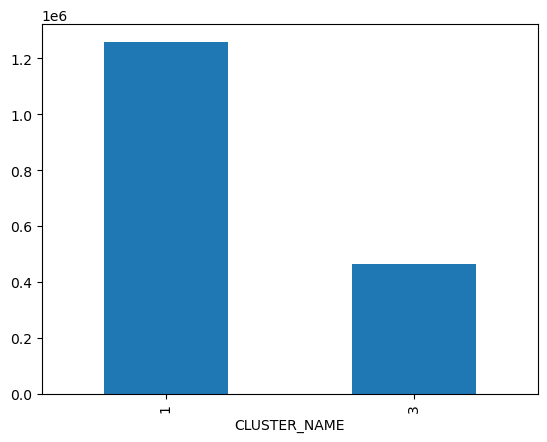

In [46]:
purchases_df.groupby('CLUSTER_NAME')["IMPORTE"].mean().plot.bar()
plt.show()

### Testing an unsupervised model for outliers respect to `IMPORTE`.

In [47]:
params = norm.fit(purchases_df["IMPORTE"])

In [48]:
purchases_df["PROB_TOTAL"] = [norm(params[0], params[1]).cdf(z) for z in purchases_df["IMPORTE"]]

In [49]:
purchases_df[purchases_df["PROB_TOTAL"] > 0.95]

,NUM BEN,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,MES,DIA,SHEET,IMPORTE,BENEFICIARIO_SALES,IMPORTE_MEDIO,HAS_LINKEDIN_SITE,CLUSTER_NAME,PROB_TOTAL
111,115716,"SOLUCIONES Y OPCIONES DE SEGURIDAD PRIVADA,S.A...",SOS070816714,426-158003-5663,SPP-347-2020,50% RESTANTE POR LA ADQUISICION DE UN SISTEMA ...,TR,297000059.0,2020-12-08,12,8,CONTRATISTAS Y FDO FED,1.134577e+07,1,474566.765787,True,3,0.989209
161,115826,"CAR ONE MONTERREY, S.A. DE C.V.",COM021025A18,DSTS3211-158003-5768,SPP-358-2020,SEGUNDO Y ULTIMO ANTICIPO DE 30% DE 77 VEHICUL...,TR,300000121.0,2020-12-18,12,18,CONTRATISTAS Y FDO FED,2.172712e+07,78,474566.765787,True,3,0.999997
166,116217,"RED RECOLECTOR, S.A. DE C.V.",RRE9712222V9,FVRM0251125-158003-5742,SSP-157-13,RECOLECCION DE RESIDUOS NO PELIGROSOS GENERADO...,TR,302000014.0,2020-12-11,12,11,CONTRATISTAS Y FDO FED,1.951267e+07,1,474566.765787,True,3,0.999974
168,116626,INTEGRACION DE SISTEMAS DE AVANZADA TECNOLOGIA...,ISA030315CN0,2865-158003-5664,SPP-354-2020,CRECIMIENTO Y AMPLIACION DE COBERTURA AL SISTE...,TR,297000058.0,2020-12-08,12,8,CONTRATISTAS Y FDO FED,1.267303e+08,5,474566.765787,True,3,1.000000
278,123674,"PROYECTOS Y DESARROLLOS SALVE, SA. DE CV.",PYD050930HQ2,B1572-155002-2903,SOP-996-2020,RE-2020 FDO-INF-MCIPAL EST. 1 OP-FIM17Y20-01/2...,TR,306000031.0,2020-12-28,12,28,CONTRATISTAS Y FDO FED,9.612407e+06,3,474566.765787,True,3,0.972955
1007,116684,"INDUSTRIAS SOLA BASIC, S.A. DE C.V.",ISB840628IB2,GS106845-158003-5868,SSP-189-2017,MANTENIMIENTO PREVENTIVO Y CORRECTIVO DE LOS T...,TR,604000051.0,2020-12-30,12,30,GASTOS VARIOS,9.000000e+06,2,881659.731797,True,3,0.963661
1077,126224,"BANCO MULTIVA, SA. G.F.M.",BMI061005NY5,FS-23-2020-158004-1712,NO APLICA,FONDO SAPS 23-2020,TR,1019137.0,2020-12-11,12,11,GASTOS VARIOS,9.071256e+06,2,881659.731797,True,1,0.964862
1078,126224,"BANCO MULTIVA, SA. G.F.M.",BMI061005NY5,FS-24-2020-158004-1751,NO APLICA,FONDO SAPS 24-2020,TR,1019152.0,2020-12-18,12,18,GASTOS VARIOS,9.078245e+06,2,881659.731797,True,1,0.964978
1081,126671,"BANCO BANCREA,S.A. ,FIDEICOMISO NUMERO BP417",BBA130722BR7,144-153001-167,NO APLICA,APORTACIÓN MUNICIPAL AL FIDEICOMISO LA GRAN CI...,TR,1019122.0,2020-12-11,12,11,GASTOS VARIOS,3.000000e+07,1,881659.731797,False,1,1.000000
1091,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-A-158004-1734,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCA ...",TR,11000196.0,2020-12-17,12,17,GASTOS VARIOS,7.386437e+07,16,881659.731797,True,1,1.000000


In [50]:
models_sheet = {}
for sheet in purchases_df["SHEET"].unique():
    sheet_purchases = purchases_df[purchases_df.SHEET == sheet]
    params = norm.fit(sheet_purchases["IMPORTE"])
    models_sheet[sheet] = norm(params[0], params[1])

In [51]:
models_sheet

{'CONTRATISTAS Y FDO FED': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f6d40100460>,
 'GASTOS VARIOS': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f6d400a7250>,
 'SERV PPROF': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f6d400a71f0>,
 'COMUNICACION': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f6d4010d550>,
 'SERV. PERS.': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f6d400a7490>}

In [52]:
sheet_prob = []
for i, row in purchases_df.iterrows():
    sheet_prob.append(models_sheet[row["SHEET"]].cdf(row["IMPORTE"]))

purchases_df["PROB_SHEET"] = sheet_prob

In [53]:
purchases_df[purchases_df["PROB_SHEET"] > 0.95]

,NUM BEN,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,MES,DIA,SHEET,IMPORTE,BENEFICIARIO_SALES,IMPORTE_MEDIO,HAS_LINKEDIN_SITE,CLUSTER_NAME,PROB_TOTAL,PROB_SHEET
111,115716,"SOLUCIONES Y OPCIONES DE SEGURIDAD PRIVADA,S.A...",SOS070816714,426-158003-5663,SPP-347-2020,50% RESTANTE POR LA ADQUISICION DE UN SISTEMA ...,TR,297000059.0,2020-12-08,12,8,CONTRATISTAS Y FDO FED,1.134577e+07,1,474566.765787,True,3,0.989209,0.986813
161,115826,"CAR ONE MONTERREY, S.A. DE C.V.",COM021025A18,DSTS3211-158003-5768,SPP-358-2020,SEGUNDO Y ULTIMO ANTICIPO DE 30% DE 77 VEHICUL...,TR,300000121.0,2020-12-18,12,18,CONTRATISTAS Y FDO FED,2.172712e+07,78,474566.765787,True,3,0.999997,0.999993
166,116217,"RED RECOLECTOR, S.A. DE C.V.",RRE9712222V9,FVRM0251125-158003-5742,SSP-157-13,RECOLECCION DE RESIDUOS NO PELIGROSOS GENERADO...,TR,302000014.0,2020-12-11,12,11,CONTRATISTAS Y FDO FED,1.951267e+07,1,474566.765787,True,3,0.999974,0.999950
168,116626,INTEGRACION DE SISTEMAS DE AVANZADA TECNOLOGIA...,ISA030315CN0,2865-158003-5664,SPP-354-2020,CRECIMIENTO Y AMPLIACION DE COBERTURA AL SISTE...,TR,297000058.0,2020-12-08,12,8,CONTRATISTAS Y FDO FED,1.267303e+08,5,474566.765787,True,3,1.000000,1.000000
278,123674,"PROYECTOS Y DESARROLLOS SALVE, SA. DE CV.",PYD050930HQ2,B1572-155002-2903,SOP-996-2020,RE-2020 FDO-INF-MCIPAL EST. 1 OP-FIM17Y20-01/2...,TR,306000031.0,2020-12-28,12,28,CONTRATISTAS Y FDO FED,9.612407e+06,3,474566.765787,True,3,0.972955,0.969020
1007,116684,"INDUSTRIAS SOLA BASIC, S.A. DE C.V.",ISB840628IB2,GS106845-158003-5868,SSP-189-2017,MANTENIMIENTO PREVENTIVO Y CORRECTIVO DE LOS T...,TR,604000051.0,2020-12-30,12,30,GASTOS VARIOS,9.000000e+06,2,881659.731797,True,3,0.963661,0.953737
1077,126224,"BANCO MULTIVA, SA. G.F.M.",BMI061005NY5,FS-23-2020-158004-1712,NO APLICA,FONDO SAPS 23-2020,TR,1019137.0,2020-12-11,12,11,GASTOS VARIOS,9.071256e+06,2,881659.731797,True,1,0.964862,0.955151
1078,126224,"BANCO MULTIVA, SA. G.F.M.",BMI061005NY5,FS-24-2020-158004-1751,NO APLICA,FONDO SAPS 24-2020,TR,1019152.0,2020-12-18,12,18,GASTOS VARIOS,9.078245e+06,2,881659.731797,True,1,0.964978,0.955287
1081,126671,"BANCO BANCREA,S.A. ,FIDEICOMISO NUMERO BP417",BBA130722BR7,144-153001-167,NO APLICA,APORTACIÓN MUNICIPAL AL FIDEICOMISO LA GRAN CI...,TR,1019122.0,2020-12-11,12,11,GASTOS VARIOS,3.000000e+07,1,881659.731797,False,1,1.000000,1.000000
1091,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-A-158004-1734,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCA ...",TR,11000196.0,2020-12-17,12,17,GASTOS VARIOS,7.386437e+07,16,881659.731797,True,1,1.000000,1.000000
